(393732, 7)
['EDL' 'KCK' 'KAK' ...
 'GQVQLVQSGGGLVQAGGSLRLSCAFSGRTFSMYTMGWFRQAPGKEREFVAANRGRGLSPDIADSVNGRFTISRDNAKNTLYLQMDSLKPEDTAVYYCAADLQYGSSWPQRSSAEYDYWGQGTTVTVSS'
 'MSGYTPDEKLRLQQLRELRRRWLKDQELSPREPVLPPRRMWPLERFWDNFLRDGAVWKNMVFKAYRSSLFAVSHVLIPMWFVHYYVKYHMATKPYTIVSSKPRIFPGDTILETGEVIPPMRDFPDQHH'
 'MSGYTPDEKLRLQQLRELRRRWLKDQELSPREPVLPPRRMWPLERFWDNFLRDGAVWKNMVFKAYRSSLFAVSHVLIPMWFVHYYVKYHMATKPYTIVSSKPRIFPGDTILETGEVIPPMRDFPDQHH']
[list(['EDL', 'DL', 'L']) list(['KCK', 'CK', 'K'])
 list(['KAK', 'AK', 'K']) ...
 list(['GQV', 'QVQ', 'VQL', 'QLV', 'LVQ', 'VQS', 'QSG', 'SGG', 'GGG', 'GGL', 'GLV', 'LVQ', 'VQA', 'QAG', 'AGG', 'GGS', 'GSL', 'SLR', 'LRL', 'RLS', 'LSC', 'SCA', 'CAF', 'AFS', 'FSG', 'SGR', 'GRT', 'RTF', 'TFS', 'FSM', 'SMY', 'MYT', 'YTM', 'TMG', 'MGW', 'GWF', 'WFR', 'FRQ', 'RQA', 'QAP', 'APG', 'PGK', 'GKE', 'KER', 'ERE', 'REF', 'EFV', 'FVA', 'VAA', 'AAN', 'ANR', 'NRG', 'RGR', 'GRG', 'RGL', 'GLS', 'LSP', 'SPD', 'PDI', 'DIA', 'IAD', 'ADS', 'DSV', 'SVN', 'VNG', 'NGR', 'GRF', 'RFT', 'FTI

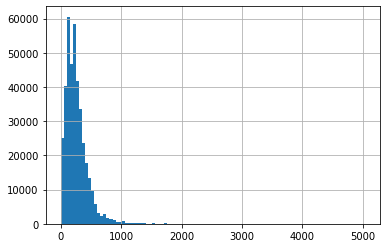

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(input_seqs)
print(input_grams)
print(target_seqs)

In [4]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

Using TensorFlow backend.


((88751, 128), (88751, 128, 4))

In [5]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 4




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [6]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 53250 samples, validate on 35501 samples
Epoch 1/5





53250/53250 [==============================] - 1569s 29ms/step - loss: 0.4110 - acc: 0.8265 - q3_acc: 0.7249 - val_loss: 0.3029 - val_acc: 0.8801 - val_q3_acc: 0.8099
Epoch 2/5
53250/53250 [==============================] - 335s 6ms/step - loss: 0.2839 - acc: 0.8878 - q3_acc: 0.8211 - val_loss: 0.2950 - val_acc: 0.8831 - val_q3_acc: 0.8148
Epoch 3/5
53250/53250 [==============================] - 337s 6ms/step - loss: 0.2501 - acc: 0.9022 - q3_acc: 0.8441 - val_loss: 0.2495 - val_acc: 0.9025 - val_q3_acc: 0.8455
Epoch 4/5
53250/53250 [==============================] - 343s 6ms/step - loss: 0.2273 - acc: 0.9116 - q3_acc: 0.8590 - val_loss: 0.2481 - val_acc: 0.9031 - val_q3_acc: 0.8464
Epoch 5/5
53250/53250 [==============================] - 619s 12ms/step - loss: 0.2103 - acc: 0.9183 - q3_acc: 0.8697 - val_loss: 0.2319 - val_a

training
---
Input: MGDKPIWEQIGSSFINHYYQLFDNDRTQLGAIYIDASCLTWEGQQFQGKAAIVEKLSSLPFQKIQHSITAQDHQPTPDSCIISMVVGQLKADEDPIMGFHQEFLLKNINDAWVCTNDMFRLALHNFG
Target: CCCCCHHHHHHHHHHHHHHHHHHHCHHHHHHHCCCCCEEEECCEEEECHHHHHHHHHHCCCCCEEEEEEEEEEEECCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCEEEEEEEEEEECCCCC
Result: CCCCCHHHHHHHHHHHHHHHHHHCCCCHHHHEEEEEEEEEECCEEEECHHHHHHHHHCCCCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCEEEEEEEEEECCCCCC


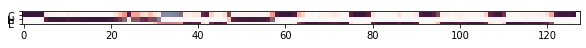

---
Input: SRGTQTE
Target: CEEEECC
Result: CCCCCCC


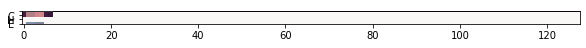

---
Input: MKEEKRSSTGFLVKQRAFLKLYMITMTEQERLYGLKLLKVLQSEFKEIGFKPNHTEVYRSLHELLDDGILKQIKVKKEGAKLQEVVLYQFKDYEAAKLYKKQLKVELDRCKKLIEKALSDNF
Target: CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCEECCCCHHHHHHHHCCCCCCCCHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCCEEEEECCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHCCCCCCCCHHHHHHHHHHHHCHCCEEEEECCCCCCCCCCEEEEECCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC


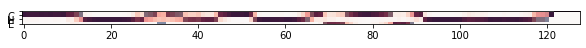

testing
---
Input: MKRQKRDRLERAHQRGYQAGIAGRSKEMCPYQTLNQRSQWLGGWREAMADRVVMAHHHHHH
Target: CCCCCHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHCCCHCCCCCCHHHHHHHHHCCHHHHHHHCCCCCCCCCCC


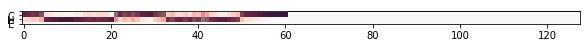

---
Input: YCQKWMWTCDEERKCCEGLVCRLWCKRIINM
Target: CCCCCCCECCCCCCCCCCCECCCECECCCCC
Result: CCCCCCCCCCCCCCEECCCCCEEEEEEEEEC


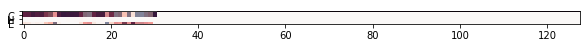

---
Input: TEFSEEQKRTLDLLFLFDRRMTEERRRWLSQRLGLNEEQIERWFRRKEQQI
Target: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCCCCCC
Result: CCCCHHHCHHHHHHHHHHHCHHHHHHHHHHHHCCCCHHHHHHHHCCCCCCC


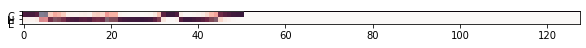

In [7]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])